In [1]:
import sys
sys.path.append('../../lib/')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from jax.example_libraries.optimizers import adam, pack_optimizer_state
from hetero_simulation.archive.agent import ces_utility, log_utility
from hetero_simulation.ml.utils import *
from hetero_simulation.econ_models.krusell_smith import opt_control, lagrange_multiplier, prices, next_state, batch_loss
from hetero_simulation.econ_models.krusell_smith import params0, config, n, mb, k, m, nn_shapes, generate_random_state, n_forward

In [7]:
_, _, get_params = adam(step_size=0.1)
# params = pickle.load(open('../models/ks_model_1000_140.pkl', 'rb'))
saved_state = pickle.load(open('../models/ks_model_1000_100.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_state)
params = get_params(opt_state)

key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
keys = jax.random.split(key, n * (k + 1)).reshape(n, (k + 1), 2)
Xs, Zs, Es, key = generate_random_state(params, config, key, n_forward=n_forward)
Xs = jnp.concatenate((Xs, Xs), axis=0)
Zs = jnp.concatenate((Zs, Zs), axis=0)
Es = jnp.concatenate((Es, Es), axis=0)
Zs_prime, Es_prime = next_state(Zs, Es, config, keys)
xs = Xs.reshape(-1, 1)

<AxesSubplot:xlabel='x', ylabel='c_star_rel'>

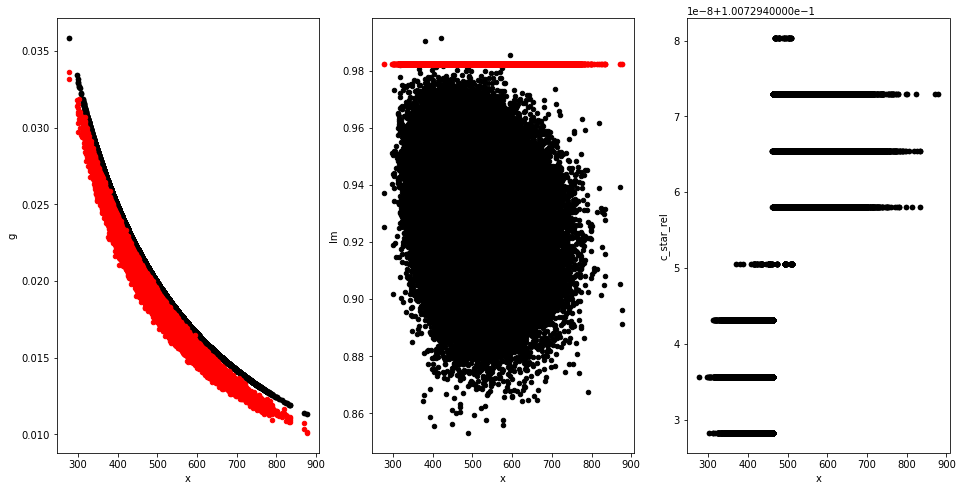

In [9]:
u = log_utility()
# v_hats = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: V_hat(params, X, Z, E[i], X[i]))(jnp.arange(k)))(Xs, Zs, Es)
Z1s, E1s = next_state(Zs, Es, config, keys)
rs, ws = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(Xs, Zs, Es)
xs = jax.vmap(lambda X, E, rt, wt: jax.vmap(lambda x, e: (rt * x) + (wt * jnp.exp(e)))(X, E))(Xs, Es, rs, ws).reshape(Xs.shape[0], -1)
cs = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: opt_control(params, X, E, Z, E[i], X[i]))(jnp.arange(k)))(xs, Zs, Es)
lms = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: lagrange_multiplier(params, X, E, Z, E[i], X[i]))(jnp.arange(k)))(xs, Zs, Es)
X1s = xs - cs
r1s, w1s = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(X1s, Z1s, E1s)
x1s = jax.vmap(lambda X, E, rt, wt: jax.vmap(lambda x, e: (rt * x) + (wt * jnp.exp(e)))(X, E))(X1s, E1s, r1s, w1s).reshape(Xs.shape[0], -1)
c1s = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: opt_control(params, X, E, Z, E[i], X[i]))(jnp.arange(k)))(x1s, Z1s, E1s)
gs = jax.vmap(lambda r, cs: jax.vmap(lambda c: config['beta'] * r * jax.grad(u)(c))(cs))(r1s, c1s)
ups = jax.grad(u)(cs)
us = jax.vmap(jax.vmap(u))(cs)
c_rels = cs / xs

df = pd.DataFrame(jnp.concatenate([xs.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                   x1s.reshape(-1, 1), lms.reshape(-1, 1),
                                   gs.reshape(-1, 1), c_rels.reshape(-1, 1),
                                   cs.reshape(-1, 1), us.reshape(-1, 1), ups.reshape(-1, 1)], axis=1))
df.columns = ['x', 'Z', 'e', 'x_prime', 'lm', 'g', 'c_star_rel', 'c_star', 'u', 'u_prime']

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
df['gf'] = df['g'] / df['u_prime']
df.plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes.flatten()[0])
df.plot(x='x', y='g', kind='scatter', color='red', ax=axes.flatten()[0])
df.plot(x='x', y='gf', kind='scatter', color='black', ax=axes.flatten()[1])
df.plot(x='x', y='lm', kind='scatter', color='red', ax=axes.flatten()[1])
df.plot(x='x', y='c_star_rel', kind='scatter', color='black', ax=axes.flatten()[2])
# df.plot(x='x', y='c_star', kind='scatter', color='red', ax=axes.flatten()[2])

In [7]:
np.mean((df['gf'] - df['lm'])**2)

0.00074127037

In [9]:
df['lm']

0         1.018469
1         1.022549
2         1.021482
3         1.022326
4         1.022185
            ...   
255995    1.022634
255996    1.018836
255997    1.022754
255998    1.020884
255999    1.021115
Name: lm, Length: 256000, dtype: float32

In [11]:
df

,x,Z,e,v_hat,x_prime,f,lm,g,c_star,c_star_rel,u,u_prime
0,0.005431,0.015286,0.111745,35.230545,0.014131,35.226620,0.057107,0.083795,0.993080,0.004732,-5.353429,211.331787
1,0.007057,0.015286,-0.351583,35.018997,0.068240,35.024113,0.023409,0.010108,0.960362,0.003092,-5.778829,323.380371
2,0.005604,0.015286,0.182270,35.282207,0.011825,35.286324,0.064039,0.082063,0.994537,0.005059,-5.286614,197.673050
3,0.006912,0.015286,-0.469248,34.902325,0.121702,34.917168,0.018888,0.000885,0.924270,0.002180,-6.128509,458.751343
4,0.006468,0.015286,-0.302839,35.009682,0.058772,35.013390,0.025985,0.013063,0.965318,0.003193,-5.746642,313.137390
...,...,...,...,...,...,...,...,...,...,...,...,...
255995,0.005432,0.026522,-0.027380,35.159950,0.020562,35.135551,0.047064,0.066564,0.989011,0.004306,-5.447701,232.223694
255996,0.005799,0.026522,0.088369,35.256943,0.014212,35.238045,0.057286,0.086332,0.993119,0.005030,-5.292390,198.817947
255997,0.005620,0.026522,0.140333,35.276363,0.012599,35.263962,0.062707,0.092899,0.994052,0.005013,-5.295632,199.463638
255998,0.005411,0.026522,0.171904,35.282040,0.011797,35.274784,0.066248,0.090116,0.994487,0.004895,-5.319458,204.273117


In [9]:
df['ex'] = df['x'].apply(lambda x: np.exp(x))
df['lnx'] = df['x'].apply(lambda x: np.log(x+1))
df['ex_prime'] = df['x'].apply(lambda x: 1/np.exp(x))
df['lnx_prime'] = df['x'].apply(lambda x: 1/np.log(x+1))

In [ ]:
fig, ax = plt.subplots()
df[df['x'] > 0].plot(x='x', y='u_prime', kind='scatter', ax=ax, color='black')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', ax=ax, color='blue')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='ex_prime', kind='scatter', ax=ax, color='red')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='lnx_prime', kind='scatter', ax=ax, color='green')

<AxesSubplot:xlabel='x', ylabel='lm'>

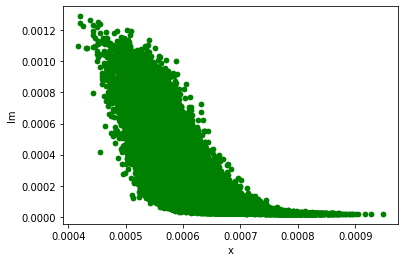

In [21]:
fig, ax = plt.subplots()
df.plot(x='x', y= 'lm', kind='scatter', color='green', ax=ax)

In [ ]:
from hetero_simulation.econ_models.krusell_smith import P, z_g, z_b
Z = Zs[0]
e = Es[0, 0]
s = 0 * ((Z == z_g) & (e == 1)) + \
    1 * ((Z == z_b) & (e == 1)) + \
    2 * ((Z == z_g) & (e == 0)) + \
    3 * ((Z == z_b) & (e == 0))
P[s]